In [10]:
#!pip install -q opendatasets

In [72]:
# Import the necessary libraries
import os
import numpy as np
import pandas as pd
import opendatasets as od
import random
import re
import matplotlib.pyplot as plt

# Random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [73]:
# Import the dataset
od.download("https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data",
    data_dir="..")


Skipping, found downloaded files in "..\credit-risk-dataset" (use force=True to force download)


In [74]:
# Define the path to the dataset
csv_path = os.path.join("..", "credit-risk-dataset", "credit_risk_dataset.csv")
df = pd.read_csv(csv_path)

In [75]:
# View the data and drop the missing values
df.head()
df = df.dropna()

Since our objective is to create a form that a customer can fill out, we need to drop the following columns:

    - loan_grade - this is something our team will evaluate.
    - loan_int_rate - not something that a customer should be able to choose arbitrarily.
    - loan_percvent_income - can be calculated from person_income and loan_amnt.
    - cb_person_cred_hist_length - we drop this for simplicity of the model and to make the form shorter.

In [76]:
df = df.drop(columns=["loan_grade", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"])

We want to have entries of cb_person_default_on_file as either 1 or 0.

In [77]:
# Map yes/no to 0/1
def yn_to01(s):
    m = s.astype(str).str.strip().str.lower()
    return m.map({"y":1,"n":0}).astype(float)

In [78]:
df["cb_person_default_on_file"] = yn_to01(df["cb_person_default_on_file"])

In [79]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_status,cb_person_default_on_file
0,22,59000,RENT,123.0,PERSONAL,35000,1,1.0
1,21,9600,OWN,5.0,EDUCATION,1000,0,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,1,0.0
3,23,65500,RENT,4.0,MEDICAL,35000,1,0.0
4,24,54400,RENT,8.0,MEDICAL,35000,1,1.0


Now we encode the person_home_ownership in hierarchical order, where we value "own" the most and "other" the least.

In [80]:
print(df["person_home_ownership"].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']


In [81]:
# Encodes person_home_ownership accounting for the hierarchy 
def hom_own(s):
    m = s.astype(str).str.strip().str.lower()
    return m.map({"other":0,"rent":1, "mortgage":2, "own":3}).astype(float)

In [82]:
df["person_home_ownership"] = hom_own(df["person_home_ownership"])

The order for loan_intent is not so obvious, therefore we use one-hot encoding in this case

In [83]:
df = pd.get_dummies(df, columns=["loan_intent"], prefix="loan_intent", drop_first=True, dtype=float)

In [84]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_amnt,loan_status,cb_person_default_on_file,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,59000,1.0,123.0,35000,1,1.0,0.0,0.0,0.0,1.0,0.0
1,21,9600,3.0,5.0,1000,0,0.0,1.0,0.0,0.0,0.0,0.0
2,25,9600,2.0,1.0,5500,1,0.0,0.0,0.0,1.0,0.0,0.0
3,23,65500,1.0,4.0,35000,1,0.0,0.0,0.0,1.0,0.0,0.0
4,24,54400,1.0,8.0,35000,1,1.0,0.0,0.0,1.0,0.0,0.0


Now it is time to train the models on this data. 

We will compare the baseline model (logistic regression) to an XGBoost model and a simple NN. 

In [88]:
# First we prepare the data for training
from sklearn.model_selection import train_test_split

data = df.copy()

X = data.drop(columns=["loan_status"]).values
y = data["loan_status"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score


model_baseline = LogisticRegression(class_weight="balanced", max_iter=1000, solver="saga")
model_baseline.fit(X_train, y_train)

y_pred = model_baseline.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Rejected: {y_pred.mean() * 100:.0f}%")
print(f"Accuracy: {precision * 100:.0f}%")
print(f"Recall: {recall * 100:.0f}%")

Rejected: 36%
Accuracy: 37%
Recall: 62%


[0]	validation-auc:0.83010	train-auc:0.84765
[20]	validation-auc:0.85065	train-auc:0.87320
[40]	validation-auc:0.86131	train-auc:0.88471
[60]	validation-auc:0.87020	train-auc:0.89665
[80]	validation-auc:0.87742	train-auc:0.90642
[100]	validation-auc:0.87958	train-auc:0.91414
[120]	validation-auc:0.88217	train-auc:0.92026
[140]	validation-auc:0.88468	train-auc:0.92498
[160]	validation-auc:0.88730	train-auc:0.93014
[180]	validation-auc:0.88972	train-auc:0.93506
[200]	validation-auc:0.89198	train-auc:0.93967
[220]	validation-auc:0.89258	train-auc:0.94247
[240]	validation-auc:0.89323	train-auc:0.94536
[260]	validation-auc:0.89497	train-auc:0.94916
[280]	validation-auc:0.89575	train-auc:0.95197
[300]	validation-auc:0.89607	train-auc:0.95391
[320]	validation-auc:0.89671	train-auc:0.95637
[340]	validation-auc:0.89729	train-auc:0.95802
[360]	validation-auc:0.89749	train-auc:0.95987
[380]	validation-auc:0.89763	train-auc:0.96184
[400]	validation-auc:0.89776	train-auc:0.96399
[420]	validation-au

<Figure size 800x600 with 0 Axes>

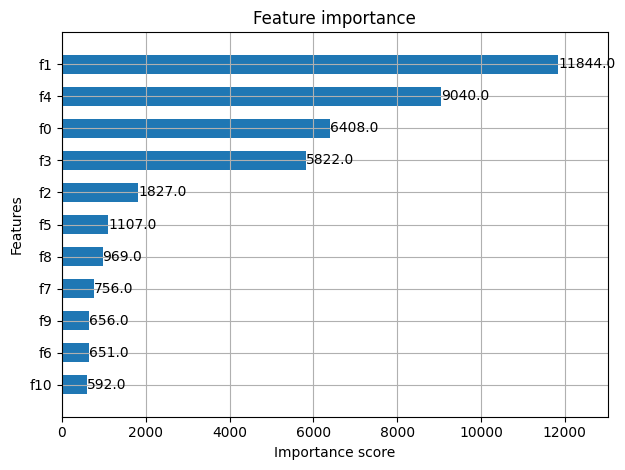

In [94]:
# python
import inspect
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix


X_df = data.drop(columns=["loan_status"]).copy()
y = data["loan_status"].astype(int).values


bool_cols = X_df.select_dtypes(include=["bool"]).columns.tolist()
for c in bool_cols:
    X_df[c] = X_df[c].astype(int)
X_df = X_df.apply(pd.to_numeric, errors="coerce")
X = X_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0

model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="auc",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

early_cb = xgb.callback.EarlyStopping(rounds=50, save_best=True)
trained_with_classifier = False

try:
    sig = inspect.signature(model.fit)
    if "callbacks" in sig.parameters:
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[early_cb],
            verbose=20
        )
        trained_with_classifier = True
    else:
        raise TypeError("fit() doesn't accept callbacks in this version")
except TypeError:

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": 0.05,
        "max_depth": 6,
        "scale_pos_weight": scale_pos_weight,
        "seed": 42,
        "nthread": -1
    }

    evals = [(dval, "validation"), (dtrain, "train")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=20
    )


if trained_with_classifier:
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    booster = model.get_booster()
else:
    y_proba = bst.predict(dtest)
    y_pred = (y_proba >= 0.5).astype(int)
    booster = bst

print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
print("Precision:", f"{precision_score(y_test, y_pred):.4f}")
print("Recall:", f"{recall_score(y_test, y_pred):.4f}")
print("ROC AUC:", f"{roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
xgb.plot_importance(booster, max_num_features=20, height=0.6)
plt.tight_layout()
plt.show()

In [86]:
import torch
print("torch:", torch.__version__)
print("cuda build:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


torch: 2.5.1+cu121
cuda build: 12.1
cuda available: True
NVIDIA GeForce GTX 1660 Ti


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [94]:
class CreditRiskNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = CreditRiskNN(input_dim=X_train.shape[1]).to(device)

In [99]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            test_preds = (model(X_test) > 0.5).float()
            acc = (test_preds.eq(y_test).sum().item()) / len(y_test)
        print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}, Test Acc={acc:.3f}")


Epoch 5/3000, Loss=0.3190, Test Acc=0.872
Epoch 10/3000, Loss=0.3182, Test Acc=0.871
Epoch 15/3000, Loss=0.3195, Test Acc=0.872
Epoch 20/3000, Loss=0.3184, Test Acc=0.871
Epoch 25/3000, Loss=0.3188, Test Acc=0.872
Epoch 30/3000, Loss=0.3184, Test Acc=0.871
Epoch 35/3000, Loss=0.3181, Test Acc=0.871
Epoch 40/3000, Loss=0.3218, Test Acc=0.872
Epoch 45/3000, Loss=0.3173, Test Acc=0.872
Epoch 50/3000, Loss=0.3193, Test Acc=0.872
Epoch 55/3000, Loss=0.3189, Test Acc=0.872
Epoch 60/3000, Loss=0.3195, Test Acc=0.871
Epoch 65/3000, Loss=0.3207, Test Acc=0.871
Epoch 70/3000, Loss=0.3182, Test Acc=0.871
Epoch 75/3000, Loss=0.3193, Test Acc=0.871
Epoch 80/3000, Loss=0.3178, Test Acc=0.872
Epoch 85/3000, Loss=0.3194, Test Acc=0.871
Epoch 90/3000, Loss=0.3192, Test Acc=0.872
Epoch 95/3000, Loss=0.3163, Test Acc=0.872
Epoch 100/3000, Loss=0.3172, Test Acc=0.871
Epoch 105/3000, Loss=0.3171, Test Acc=0.871
Epoch 110/3000, Loss=0.3175, Test Acc=0.871
Epoch 115/3000, Loss=0.3183, Test Acc=0.871
Epoch 12